Ref: Machine Learning Mastery

In [89]:
!pip install xgboost

     ---------------------------------------- 89.1/89.1 MB 3.3 MB/s eta 0:00:00


In [91]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
import numpy as np

from sklearn.datasets import make_classification, make_regression
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, LinearRegression, SGDClassifier
from sklearn.linear_model import SGDRegressor, RidgeClassifier, PassiveAggressiveClassifier, PassiveAggressiveRegressor
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor, RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor, AdaBoostClassifier, AdaBoostRegressor
from sklearn.ensemble import BaggingClassifier, BaggingRegressor
from sklearn.model_selection import KFold, cross_val_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, SVR
from sklearn.tree import ExtraTreeClassifier, ExtraTreeRegressor, DecisionTreeClassifier, DecisionTreeRegressor
from xgboost import XGBClassifier

In [77]:
def load_data():
    X, y = make_classification(n_samples=1000, n_features=20, random_state=1)
    #Info : we know that random state is just like setting seed for random number generator.
    #It ensures that we get the same values at evry execution
    return X, y

In [86]:
def make_models():
    #creating a dict of models with {name: obj}
    models = dict()
    #Linear Models
    models['LR'] = LogisticRegression()
    models['LSVM'] = SGDClassifier() #Stochastic gradient descent for SVM with hinge loss
    alpha = np.linspace(0.1, 1.0, 10)
    for a in alpha:
        models['Ridge_'+str(a)] = RidgeClassifier(alpha=a)
    models['PAC'] = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)
    #Non Linear Models
    neighbors = np.arange(1, 11)
    for k in neighbors:
        models['KNN_'+str(k)] = KNeighborsClassifier(n_neighbors=k)
    models['CART'] = DecisionTreeClassifier()
    models['EXTRA'] = ExtraTreeClassifier()
    models['NBayes'] = GaussianNB()
    models['SVML'] = SVC(kernel='linear')
    models['SVMP'] = SVC(kernel='poly')
    c_values = np.linspace(0.1, 1.0, 10)
    for c in c_values:
        models['SVM_C_'+str(c)] = SVC(C=c)
    #Ensemble Models
    n_trees = 100 
    models['RF'] = RandomForestClassifier(n_estimators=n_trees)
    models['ExtraTrees'] = ExtraTreesClassifier(n_estimators=n_trees)
    models['ADBC'] = AdaBoostClassifier(n_estimators=n_trees)
    models['BagC'] = BaggingClassifier(n_estimators=n_trees)
    models['GDBC'] = GradientBoostingClassifier(n_estimators=n_trees)
    print(f"Total defined models {len(models)}")
    return models

In [87]:
# Defining gradient boosting models - Course Grid Search for Gradient Boosting

#By default, the function will use XGBoost models, but can use the sklearn gradient boosting model if the use_xgb argument to the function is set to False.
#Again, we are not trying to optimally tune GBM on the problem, only very quickly find an area in the configuration space that may be worth investigating further.
def define_gbm_models(models=dict(), use_xgb=True):
    # define config ranges
    rates = [0.001, 0.01, 0.1]
    trees = [50, 100]
    ss = [0.5, 0.7, 1.0]
    depth = [3, 7, 9]
    # add configurations
    for l in rates:
        for e in trees:
            for s in ss:
                for d in depth:
                    cfg = [l, e, s, d]
                    if use_xgb:
                        name = 'xgb-' + str(cfg)
                        models[name] = XGBClassifier(learning_rate=l, n_estimators=e, subsample=s, max_depth=d)
                    else:
                        name = 'gbm-' + str(cfg)
                        models[name] = GradientBoostingClassifier(learning_rate=l, n_estimators=e, subsample=s, max_depth=d)
    print('Defined %d models' % len(models))
    return models

In [57]:
def make_pipeline(model):
    steps = list()
    #Standardization to make mean of 0 and unit sd.Tranforming to make the dist as normal distribution(z=x-mu/sigma)
    steps.append(('standardize', StandardScaler()))
    #Normalization - Similar scaling - all values will be between 0 and 1 or min/max
    steps.append(('normalize', MinMaxScaler()))
    #Modeling at the end of pipeline
    steps.append(('model', model))
    #pipeline
    pipe = Pipeline(steps)
    return pipe

In [58]:
def evaluate(X, y, pipe, cv, metric='accuracy'):
    #this evaluate will show warnings and exceptions if any for better tracking
    scores = cross_val_score(pipe, X, y, cv=cv, scoring=metric, n_jobs=-1)
    #njobs = -1 is necessary to ensure the jobs to run parallely on all the existing hardware cores
    return scores

In [59]:
def robust_evaluate(X, y, pipe, cv, metric='accuracy'):
    scores = None
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings('ignore') #ignores the warning messages
            scores = cross_val_score(pipe, X, y, cv=cv, scoring=metric, n_jobs=-1)
            #njobs = -1 is necessary to ensure the jobs to run parallely on all the existing hardware cores
    except:
        #if there is an exception while running any of the model, we are setting the score to None to make the execution run to pass
        scores=None
    return scores

In [82]:
def get_results(models):
    results = dict()
    for name, model in models.items():
        pipe = make_pipeline(model)
        cv = KFold(n_splits=10, random_state=0, shuffle=True)
#         scores = evaluate(X, y, pipe, cv)
        scores = robust_evaluate(X, y, pipe, cv)    
        if scores is not None:
            results[name] = scores
            print("Model - %s,  Mean score - %.2f, Standard Deviation - %.2f" % (name, np.mean(scores), np.std(scores)))
        else:
            print('>%s: error' % name)
    return results

In [61]:
def plot_results(results, top_n=10, maximize=True):
    if len(results) == 0:
        print("no results")
        return
    mean_scores = [(k, np.mean(v)) for k,v in results.items()]
    #sorting the mean scores
    sorted_mean_scores = sorted(mean_scores, key=lambda x: x[1])
    #reverse for descending order (e.g. for accuracy)
    if maximize:
        sorted_mean_scores = list(reversed(sorted_mean_scores))
    #determine how many results to summarize
    n = min(top_n, len(results))
    #Retrieving the names and scores of top n
    names = [x[0] for x in sorted_mean_scores[:n]]
    actual_scores = [results[x[0]] for x in sorted_mean_scores[:n]]
    for i in range(n):
        name = names[i]
        mean, std = np.mean(results[name]), np.std(results[name])
        print('Rank=%d, Name=%s, Score=%.3f sd=(+/- %.3f)' % (i+1, name, mean, std))
    #plotting
    plt.boxplot(actual_scores, labels=names)
    _, labels = plt.xticks()
    plt.setp(labels, rotation=90)
    

Total defined models 43
Defined 97 models
Model - LR,  Mean score - 0.85, Standard Deviation - 0.04
Model - LSVM,  Mean score - 0.81, Standard Deviation - 0.06
Model - Ridge_0.1,  Mean score - 0.84, Standard Deviation - 0.04
Model - Ridge_0.2,  Mean score - 0.84, Standard Deviation - 0.04
Model - Ridge_0.30000000000000004,  Mean score - 0.84, Standard Deviation - 0.04
Model - Ridge_0.4,  Mean score - 0.84, Standard Deviation - 0.04
Model - Ridge_0.5,  Mean score - 0.84, Standard Deviation - 0.04
Model - Ridge_0.6,  Mean score - 0.84, Standard Deviation - 0.04
Model - Ridge_0.7000000000000001,  Mean score - 0.84, Standard Deviation - 0.04
Model - Ridge_0.8,  Mean score - 0.84, Standard Deviation - 0.04
Model - Ridge_0.9,  Mean score - 0.84, Standard Deviation - 0.04
Model - Ridge_1.0,  Mean score - 0.84, Standard Deviation - 0.04
Model - PAC,  Mean score - 0.70, Standard Deviation - 0.13
Model - KNN_1,  Mean score - 0.73, Standard Deviation - 0.04
Model - KNN_2,  Mean score - 0.70, Stan

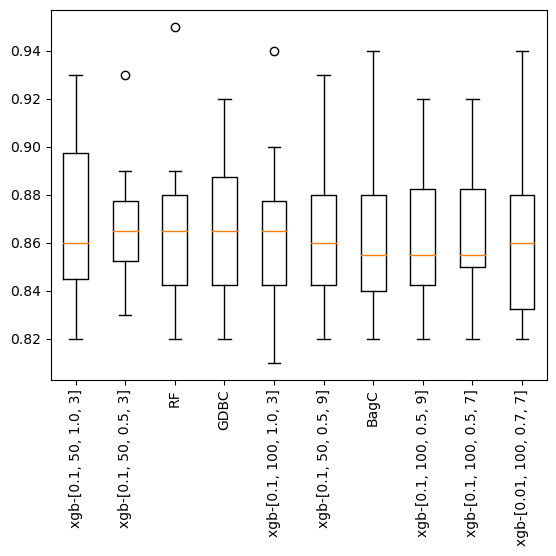

In [92]:
X, y = load_data()
models = make_models()
# add gbm models
models = define_gbm_models(models) #we are adding the gbm models to the existing models.the func() contains models as dict kw param

results = get_results(models)
plot_results(results)


#### Observation:
    We can see that ensembles of decision trees and indeed some XGBoost models perform well on the problem.. This suggests a few things:
    Ensembles of decision trees might be a good place to focus attention.
    XGBoost and Gradient boosting will likely do well if further tuned.
    A "good" performance on the problem is about 87% accuracy.
    
    If this were a real classification problem, I would follow-up with further spot checks, such as:
        - Spot check with various different feature selection methods.
        - Spot check without data scaling methods.
        - Spot check with a course grid of configurations for gradient boosting in sklearn or XGBoost.

Defined 80 models
>lr: -0.011 (+/-0.001)
>lasso-0.0: -0.011 (+/-0.001)
>lasso-0.1: -4.756 (+/-0.808)
>lasso-0.2: -18.996 (+/-3.268)
>lasso-0.3: -42.730 (+/-7.379)
>lasso-0.4: -75.957 (+/-13.144)
>lasso-0.5: -118.679 (+/-20.561)
>lasso-0.6: -170.895 (+/-29.631)
>lasso-0.7: -232.605 (+/-40.354)
>lasso-0.8: -303.810 (+/-52.729)
>lasso-0.9: -384.509 (+/-66.757)
>lasso-1.0: -474.701 (+/-82.438)
>ridge-0.0: -0.011 (+/-0.001)
>ridge-0.1: -0.902 (+/-0.167)
>ridge-0.2: -3.534 (+/-0.668)
>ridge-0.3: -7.847 (+/-1.492)
>ridge-0.4: -13.780 (+/-2.628)
>ridge-0.5: -21.277 (+/-4.064)
>ridge-0.6: -30.283 (+/-5.788)
>ridge-0.7: -40.744 (+/-7.790)
>ridge-0.8: -52.610 (+/-10.059)
>ridge-0.9: -65.831 (+/-12.586)
>ridge-1.0: -80.359 (+/-15.361)
>en-0.0: -0.011 (+/-0.001)
>en-0.1: -14332.198 (+/-2515.878)
>en-0.2: -19687.958 (+/-3396.972)
>en-0.3: -22193.163 (+/-3800.204)
>en-0.4: -23640.200 (+/-4031.347)
>en-0.5: -24581.450 (+/-4181.446)
>en-0.6: -25242.656 (+/-4286.769)
>en-0.7: -25732.412 (+/-4364.561)
>e

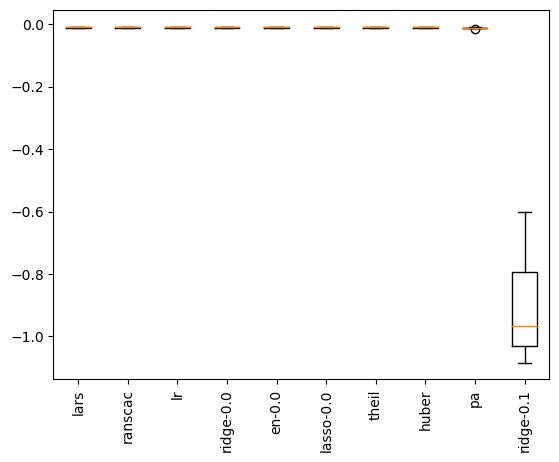

In [85]:
import warnings
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.datasets import make_regression
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import HuberRegressor
from sklearn.linear_model import Lars
from sklearn.linear_model import LassoLars
from sklearn.linear_model import PassiveAggressiveRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import TheilSenRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import ExtraTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
 
# load the dataset, returns X and y elements
def load_dataset():
    return make_regression(n_samples=1000, n_features=50, noise=0.1, random_state=1)
 
# create a dict of standard models to evaluate {name:object}
def get_models(models=dict()):
    # linear models
    models['lr'] = LinearRegression()
    alpha = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for a in alpha:
        models['lasso-'+str(a)] = Lasso(alpha=a)
    for a in alpha:
        models['ridge-'+str(a)] = Ridge(alpha=a)
    for a1 in alpha:
        name = 'en-' + str(a1)
        models[name] = ElasticNet(a1)
    models['huber'] = HuberRegressor()
    models['lars'] = Lars()
    models['llars'] = LassoLars()
    models['pa'] = PassiveAggressiveRegressor(max_iter=1000, tol=1e-3)
    models['ranscac'] = RANSACRegressor()
    models['sgd'] = SGDRegressor(max_iter=1000, tol=1e-3)
    models['theil'] = TheilSenRegressor()
    # non-linear models
    n_neighbors = range(1, 21)
    for k in n_neighbors:
        models['knn-'+str(k)] = KNeighborsRegressor(n_neighbors=k)
    models['cart'] = DecisionTreeRegressor()
    models['extra'] = ExtraTreeRegressor()
    models['svml'] = SVR(kernel='linear')
    models['svmp'] = SVR(kernel='poly')
    c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for c in c_values:
        models['svmr'+str(c)] = SVR(C=c)
    # ensemble models
    n_trees = 100
    models['ada'] = AdaBoostRegressor(n_estimators=n_trees)
    models['bag'] = BaggingRegressor(n_estimators=n_trees)
    models['rf'] = RandomForestRegressor(n_estimators=n_trees)
    models['et'] = ExtraTreesRegressor(n_estimators=n_trees)
    models['gbm'] = GradientBoostingRegressor(n_estimators=n_trees)
    print('Defined %d models' % len(models))
    return models
 
# create a feature preparation pipeline for a model
def make_pipeline(model):
    steps = list()
    # standardization
    steps.append(('standardize', StandardScaler()))
    # normalization
    steps.append(('normalize', MinMaxScaler()))
    # the model
    steps.append(('model', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline
 
# evaluate a single model
def evaluate_model(X, y, model, folds, metric):
    # create the pipeline
    pipeline = make_pipeline(model)
    # evaluate model
    scores = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
    return scores
 
# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, folds, metric):
    scores = None
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            scores = evaluate_model(X, y, model, folds, metric)
    except:
        scores = None
    return scores
 
# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, folds=10, metric='accuracy'):
    results = dict()
    for name, model in models.items():
        # evaluate the model
        scores = robust_evaluate_model(X, y, model, folds, metric)
        # show process
        if scores is not None:
            # store a result
            results[name] = scores
            mean_score, std_score = mean(scores), std(scores)
            print('>%s: %.3f (+/-%.3f)' % (name, mean_score, std_score))
        else:
            print('>%s: error' % name)
    return results
 
# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
    # check for no results
    if len(results) == 0:
        print('no results')
        return
    # determine how many results to summarize
    n = min(top_n, len(results))
    # create a list of (name, mean(scores)) tuples
    mean_scores = [(k,mean(v)) for k,v in results.items()]
    # sort tuples by mean score
    mean_scores = sorted(mean_scores, key=lambda x: x[1])
    # reverse for descending order (e.g. for accuracy)
    if maximize:
        mean_scores = list(reversed(mean_scores))
    # retrieve the top n for summarization
    names = [x[0] for x in mean_scores[:n]]
    scores = [results[x[0]] for x in mean_scores[:n]]
    # print the top n
    for i in range(n):
        name = names[i]
        mean_score, std_score = mean(results[name]), std(results[name])
        print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
    # boxplot for the top n
    pyplot.boxplot(scores, labels=names)
    _, labels = pyplot.xticks()
    pyplot.setp(labels, rotation=90)
 
# load dataset
X, y = load_dataset()
# get model list
models = get_models()
# evaluate models
results = evaluate_models(X, y, models, metric='neg_mean_squared_error')
# summarize results
summarize_results(results)

#### Observation:
    We can see that many of the linear algorithms perhaps found the same optimal solution on this problem.All of them typically have very less mse(0.011) where as on the other side ridge_0.1 has highest mse error 0.902.  Notably those methods that performed well use regularization as a type of feature selection, allowing them to zoom in on the optimal solution.

    This would suggest the importance of feature selection when modeling this problem and that linear methods would be the area to focus, at least for now.

    Reviewing the printed scores of evaluated models also shows how poorly nonlinear and ensemble algorithms performed on this problem.

#### We can also make use of spot checking with different pipelines like pipe with only model, pipe with only standardization, pipe with only normalization, pipe with standardization and normalization 

Defined 53 models
>0logistic: 0.844 (+/-0.043)
>1logistic: 0.844 (+/-0.043)
>2logistic: 0.848 (+/-0.034)
>3logistic: 0.848 (+/-0.034)
>0ridge-0.1: 0.845 (+/-0.038)
>1ridge-0.1: 0.845 (+/-0.038)
>2ridge-0.1: 0.845 (+/-0.038)
>3ridge-0.1: 0.845 (+/-0.038)
>0ridge-0.2: 0.845 (+/-0.038)
>1ridge-0.2: 0.845 (+/-0.038)
>2ridge-0.2: 0.845 (+/-0.038)
>3ridge-0.2: 0.845 (+/-0.038)
>0ridge-0.3: 0.845 (+/-0.038)
>1ridge-0.3: 0.845 (+/-0.038)
>2ridge-0.3: 0.845 (+/-0.038)
>3ridge-0.3: 0.845 (+/-0.038)
>0ridge-0.4: 0.845 (+/-0.038)
>1ridge-0.4: 0.845 (+/-0.038)
>2ridge-0.4: 0.845 (+/-0.038)
>3ridge-0.4: 0.845 (+/-0.038)
>0ridge-0.5: 0.845 (+/-0.038)
>1ridge-0.5: 0.845 (+/-0.038)
>2ridge-0.5: 0.845 (+/-0.038)
>3ridge-0.5: 0.845 (+/-0.038)
>0ridge-0.6: 0.845 (+/-0.038)
>1ridge-0.6: 0.845 (+/-0.038)
>2ridge-0.6: 0.845 (+/-0.038)
>3ridge-0.6: 0.845 (+/-0.038)
>0ridge-0.7: 0.845 (+/-0.038)
>1ridge-0.7: 0.845 (+/-0.038)
>2ridge-0.7: 0.846 (+/-0.039)
>3ridge-0.7: 0.846 (+/-0.039)
>0ridge-0.8: 0.845 (+/-0.0

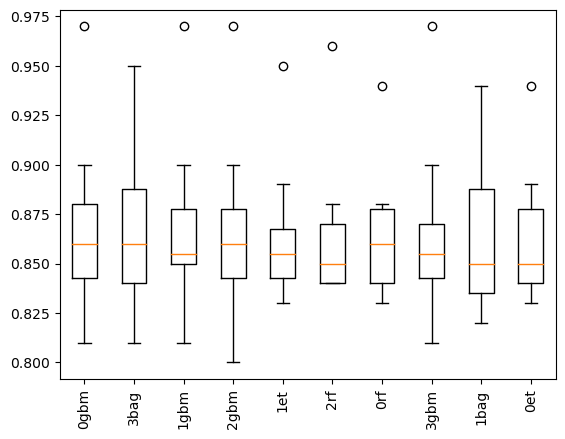

In [93]:
import warnings
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
 
# load the dataset, returns X and y elements
def load_dataset():
	return make_classification(n_samples=1000, n_classes=2, random_state=1)
 
# create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
	# linear models
	models['logistic'] = LogisticRegression()
	alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for a in alpha:
		models['ridge-'+str(a)] = RidgeClassifier(alpha=a)
	models['sgd'] = SGDClassifier(max_iter=1000, tol=1e-3)
	models['pa'] = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)
	# non-linear models
	n_neighbors = range(1, 21)
	for k in n_neighbors:
		models['knn-'+str(k)] = KNeighborsClassifier(n_neighbors=k)
	models['cart'] = DecisionTreeClassifier()
	models['extra'] = ExtraTreeClassifier()
	models['svml'] = SVC(kernel='linear')
	models['svmp'] = SVC(kernel='poly')
	c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
	for c in c_values:
		models['svmr'+str(c)] = SVC(C=c)
	models['bayes'] = GaussianNB()
	# ensemble models
	n_trees = 100
	models['ada'] = AdaBoostClassifier(n_estimators=n_trees)
	models['bag'] = BaggingClassifier(n_estimators=n_trees)
	models['rf'] = RandomForestClassifier(n_estimators=n_trees)
	models['et'] = ExtraTreesClassifier(n_estimators=n_trees)
	models['gbm'] = GradientBoostingClassifier(n_estimators=n_trees)
	print('Defined %d models' % len(models))
	return models
 
# no transforms pipeline
def pipeline_none(model):
	return model
 
# standardize transform pipeline
def pipeline_standardize(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline
 
# normalize transform pipeline
def pipeline_normalize(model):
	steps = list()
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline
 
# standardize and normalize pipeline
def pipeline_std_norm(model):
	steps = list()
	# standardization
	steps.append(('standardize', StandardScaler()))
	# normalization
	steps.append(('normalize', MinMaxScaler()))
	# the model
	steps.append(('model', model))
	# create pipeline
	pipeline = Pipeline(steps=steps)
	return pipeline
 
# evaluate a single model
def evaluate_model(X, y, model, folds, metric, pipe_func):
	# create the pipeline
	pipeline = pipe_func(model)
	# evaluate model
	scores = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
	return scores
 
# evaluate a model and try to trap errors and and hide warnings
def robust_evaluate_model(X, y, model, folds, metric, pipe_func):
	scores = None
	try:
		with warnings.catch_warnings():
			warnings.filterwarnings("ignore")
			scores = evaluate_model(X, y, model, folds, metric, pipe_func)
	except:
		scores = None
	return scores
 
# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, pipe_funcs, folds=10, metric='accuracy'):
	results = dict()
	for name, model in models.items():
		# evaluate model under each preparation function
		for i in range(len(pipe_funcs)):
			# evaluate the model
			scores = robust_evaluate_model(X, y, model, folds, metric, pipe_funcs[i])
			# update name
			run_name = str(i) + name
			# show process
			if scores is not None:
				# store a result
				results[run_name] = scores
				mean_score, std_score = mean(scores), std(scores)
				print('>%s: %.3f (+/-%.3f)' % (run_name, mean_score, std_score))
			else:
				print('>%s: error' % run_name)
	return results
 
# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
	# check for no results
	if len(results) == 0:
		print('no results')
		return
	# determine how many results to summarize
	n = min(top_n, len(results))
	# create a list of (name, mean(scores)) tuples
	mean_scores = [(k,mean(v)) for k,v in results.items()]
	# sort tuples by mean score
	mean_scores = sorted(mean_scores, key=lambda x: x[1])
	# reverse for descending order (e.g. for accuracy)
	if maximize:
		mean_scores = list(reversed(mean_scores))
	# retrieve the top n for summarization
	names = [x[0] for x in mean_scores[:n]]
	scores = [results[x[0]] for x in mean_scores[:n]]
	# print the top n
	print()
	for i in range(n):
		name = names[i]
		mean_score, std_score = mean(results[name]), std(results[name])
		print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	# boxplot for the top n
	pyplot.boxplot(scores, labels=names)
	_, labels = pyplot.xticks()
	pyplot.setp(labels, rotation=90)
	pyplot.savefig('spotcheck.png')
 
# load dataset
X, y = load_dataset()
# get model list
models = define_models()
# define transform pipelines
pipelines = [pipeline_none, pipeline_standardize, pipeline_normalize, pipeline_std_norm]
# evaluate models
results = evaluate_models(X, y, models, pipelines)
# summarize results
summarize_results(results)

#### Repeated Evaluations:
    We are using k-fold cross-validation to produce a population of scores, but the population is small and the calculated mean will be noisy meaning, each run of the model yields diffrerent mean scores.This is due because of randomness within kfold split or even the algorithm randomness.Because of this, there will be variance in model scores for each run. When evaluating stochastic algorithms like bagged or boosted decision trees, it is a good idea to run each experiment multiple times on the same train/test sets (called repeats) in order to account for the stochastic nature of the learning algorithm.Alternately, you may prefer to calculate a mean score from each k-fold cross-validation run, then calculate a grand mean of all runs
     
    Incase of random normal 66% and 34% split, For every new split of training and test set, the model produce results with some noise or variance. We call this type of limited variance, stochastic and the algorithms that exploit it, stochastic algorithms.A problem is that if we spit the training dataset again into a different 66%/34% split, we would get a different result from our algorithm. This is called model variance.
   
     A solution to our problem with the split test getting different results on different splits of the dataset is to reduce the variance of the random process and do it many times. We can collect the results from a fair number of runs (say 10) and take the average.For example, let’s say we split our dataset 66%/34%, ran our algorithm and got an accuracy and we did this 10 times with 10 different splits. We might have 10 accuracy scores as follows: 87, 87, 88, 89, 88, 86, 88, 87, 88, 87.
    But  problem with multiple split tests is that it is possible that some data instance are never included for training or testing, where as others may be selected multiple times. The effect is that this may skew results and may not give an meaningful idea of the accuracy of the algorithm.The average performance of our model is 87.5, with a standard deviation of about 0.85.
    
    A solution to the problem of ensuring each instance is used for training and testing an equal number of times while reducing the variance of an accuracy score is to use cross validation. Specifically k-fold cross validation, where k is the number of splits to make in the dataset.
    
    For example, let’s choose a value of k=10 (very common). This will split the dataset into 10 parts (10 folds) and the algorithm will be run 10 times. Each time the algorithm is run, it will be trained on 90% of the data and tested on 10%, and each run of the algorithm will change which 10% of the data the algorithm is tested on.In this example, each data instance will be used as a training instance exactly 9 times and as a test instance 1 time. The accuracy will not be a mean and a standard deviation, but instead will be an exact accuracy score of how many correct predictions were made.
    
    Cross validation does give an unbiased estimation of the algorithms performance on unseen data, but what if the algorithm itself uses randomness. The algorithm would produce different results for the same training data each time it was trained with a different random number seed (start of the sequence of pseudo-randomness). Cross validation does not account for variance in the algorithm’s predictions.(we can observe algorithm giving different results when changing the seed of make classification in the above code)
    
    Another point of concern is that cross validation itself uses randomness to decide how to split the dataset into k folds. Cross validation does not estimate how the algorithm perform with different sets of folds.
    
    A way to account for the variance in the algorithm itself is to run cross validation multiple times and take the mean and the standard deviation of the algorithm accuracy from each run.This will will give you an an estimate of the performance of the algorithm on the dataset and an estimation of how robust (the size of the standard deviation) the performance is.
    
    Lets say in this case, if you have one mean and standard deviation for algorithm A and another mean and standard deviation for algorithm B and they differ (for example, algorithm A has a higher accuracy), how do you know if the difference is meaningful?
    
    A solution to comparing algorithm performance measures when using multiple runs of k-fold cross validation is to use statistical significance tests (like the Student’s t-test).The results from multiple runs of k-fold cross validation is a list of numbers. We like to summarize these numbers using the mean and standard deviation. You can think of these numbers as a sample from an underlying population. A statistical significance test answers the question: are two samples drawn from the same population? (no difference). If the answer is “yes”, then, even if the mean and standard deviations differ, the difference can be said to be not statistically significant.
    
    We can use statistical significance tests to give meaning to the differences between algorithm results when using multiple runs (like multiple runs of k-fold cross validation with different random number seeds). This can when we want to make accurate claims about results (algorithm A was better than algorithm B and the difference was statistically significant).This is not the end of the story, because there are different statistical significance tests (parametric and nonparametric) and parameters to those tests (p-value).

In [96]:
# binary classification spot check script
import warnings
from numpy import mean
from numpy import std
from matplotlib import pyplot
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RidgeClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import ExtraTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import GradientBoostingClassifier
 
# load the dataset, returns X and y elements
def load_dataset():
    return make_classification(n_samples=1000, n_classes=2, random_state=1)
 
# create a dict of standard models to evaluate {name:object}
def define_models(models=dict()):
    # linear models
    models['logistic'] = LogisticRegression()
    alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for a in alpha:
        models['ridge-'+str(a)] = RidgeClassifier(alpha=a)
    models['sgd'] = SGDClassifier(max_iter=1000, tol=1e-3)
    models['pa'] = PassiveAggressiveClassifier(max_iter=1000, tol=1e-3)
    # non-linear models
    n_neighbors = range(1, 21)
    for k in n_neighbors:
        models['knn-'+str(k)] = KNeighborsClassifier(n_neighbors=k)
    models['cart'] = DecisionTreeClassifier()
    models['extra'] = ExtraTreeClassifier()
    models['svml'] = SVC(kernel='linear')
    models['svmp'] = SVC(kernel='poly')
    c_values = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
    for c in c_values:
        models['svmr'+str(c)] = SVC(C=c)
    models['bayes'] = GaussianNB()
    # ensemble models
    n_trees = 100
    models['ada'] = AdaBoostClassifier(n_estimators=n_trees)
    models['bag'] = BaggingClassifier(n_estimators=n_trees)
    models['rf'] = RandomForestClassifier(n_estimators=n_trees)
    models['et'] = ExtraTreesClassifier(n_estimators=n_trees)
    models['gbm'] = GradientBoostingClassifier(n_estimators=n_trees)
    print('Defined %d models' % len(models))
    return models
 
# create a feature preparation pipeline for a model
def make_pipeline(model):
    steps = list()
    # standardization
    steps.append(('standardize', StandardScaler()))
    # normalization
    steps.append(('normalize', MinMaxScaler()))
    # the model
    steps.append(('model', model))
    # create pipeline
    pipeline = Pipeline(steps=steps)
    return pipeline
 
# evaluate a single model
def evaluate_model(X, y, model, folds, repeats, metric):
    # create the pipeline
    pipeline = make_pipeline(model)
    # evaluate model
    scores = list()
    # rEpeat model evaluation n times
    for _ in range(repeats):
        # perform run
        scores_r = cross_val_score(pipeline, X, y, scoring=metric, cv=folds, n_jobs=-1)
        # add scores to list
        scores += scores_r.tolist()
        print("scores")
        print(scores)
    return scores
 
# evaluate a model and try to trap errors and hide warnings
def robust_evaluate_model(X, y, model, folds, repeats, metric):
    scores = None
    try:
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore")
            scores = evaluate_model(X, y, model, folds, repeats, metric)
    except:
        scores = None
    return scores
 
# evaluate a dict of models {name:object}, returns {name:score}
def evaluate_models(X, y, models, folds=10, repeats=3, metric='accuracy'):
    results = dict()
    for name, model in models.items():
        # evaluate the model
        scores = robust_evaluate_model(X, y, model, folds, repeats, metric)
        # show process
        if scores is not None:
            # store a result
            results[name] = scores
            mean_score, std_score = mean(scores), std(scores)
            print('>%s: %.3f (+/-%.3f)' % (name, mean_score, std_score))
        else:
            print('>%s: error' % name)
    return results
 
# print and plot the top n results
def summarize_results(results, maximize=True, top_n=10):
    # check for no results
    if len(results) == 0:
        print('no results')
        return
    # determine how many results to summarize
    n = min(top_n, len(results))
    # create a list of (name, mean(scores)) tuples
    mean_scores = [(k,mean(v)) for k,v in results.items()]
    # sort tuples by mean score
    mean_scores = sorted(mean_scores, key=lambda x: x[1])
    # reverse for descending order (e.g. for accuracy)
    if maximize:
        mean_scores = list(reversed(mean_scores))
# retrieve the top n for summarization
	names = [x[0] for x in mean_scores[:n]]
	scores = [results[x[0]] for x in mean_scores[:n]]
	# print the top n
	print()
	for i in range(n):
		name = names[i]
		mean_score, std_score = mean(results[name]), std(results[name])
		print('Rank=%d, Name=%s, Score=%.3f (+/- %.3f)' % (i+1, name, mean_score, std_score))
	# boxplot for the top n
	pyplot.boxplot(scores, labels=names)
	_, labels = pyplot.xticks()
	pyplot.setp(labels, rotation=90)
	pyplot.savefig('spotcheck.png')
 
# load dataset
X, y = load_dataset()
# get model list
models = define_models()
# evaluate models
results = evaluate_models(X, y, models)
# summarize results
summarize_results(results)

TabError: inconsistent use of tabs and spaces in indentation (998903970.py, line 85)